# Fake News Detection Tool 

#Installing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rifib\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rifib\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rifib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Load the Datasets

In [2]:
fnn_train = pd.read_csv('fnn_train.csv')
fnn_dev = pd.read_csv('fnn_dev.csv')
fnn_test = pd.read_csv('fnn_test.csv')

liar_train = pd.read_csv('liar_train.csv')
liar_dev = pd.read_csv('liar_dev.csv')
liar_test = pd.read_csv('liar_test.csv')


#Preprocessing and Data Cleaning

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Cleans and preprocesses the input text with lemmatization."""
    # Lowercasing and removing unwanted patterns
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text) 
    text = re.sub('https?://\S+|www\.\S+', '', text) 
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\s+', ' ', text).strip()
    
    # Stopword Removal and Lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    
    return text

#Text Preprocessing Visualization

In [4]:
def preprocess_text_and_measure(text):
    """Preprocess text and return both original and processed text lengths and word counts."""
    original_length = len(text)
    original_word_count = len(text.split())
    processed_text = preprocess_text(text)
    processed_length = len(processed_text)
    processed_word_count = len(processed_text.split())
    return original_length, original_word_count, processed_length, processed_word_count

def visualize_text_transformations(data, num_samples=100):
    """Visualizes how text is transformed by preprocessing using graphs."""
    # Sample the data and apply the preprocessing and measuring function
    sampled_data = data.sample(n=num_samples, random_state=1)
    measurements = sampled_data['statement'].apply(preprocess_text_and_measure)
    
    # Create DataFrame for easier plotting
    measurements_df = pd.DataFrame(measurements.tolist(), columns=['Original Length', 'Original Words', 'Processed Length', 'Processed Words'])
    
    # Plotting the average lengths and word counts before and after preprocessing
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    sns.barplot(data=measurements_df[['Original Length', 'Processed Length']], ax=axes[0], errorbar=None)
    axes[0].set_title('Average Length of Statements')
    axes[0].set_ylabel('Average Characters')
    sns.barplot(data=measurements_df[['Original Words', 'Processed Words']], ax=axes[1], errorbar=None)
    axes[1].set_title('Average Word Count of Statements')
    axes[1].set_ylabel('Average Words')
    
    plt.tight_layout()
    plt.show()

    # Histograms for word count distributions
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(measurements_df['Original Words'], bins=30, ax=axes[0], color='skyblue')
    axes[0].set_title('Distribution of Word Counts (Original)')
    sns.histplot(measurements_df['Processed Words'], bins=30, ax=axes[1], color='lightgreen')
    axes[1].set_title('Distribution of Word Counts (Processed)')
    
    plt.tight_layout()
    plt.show()

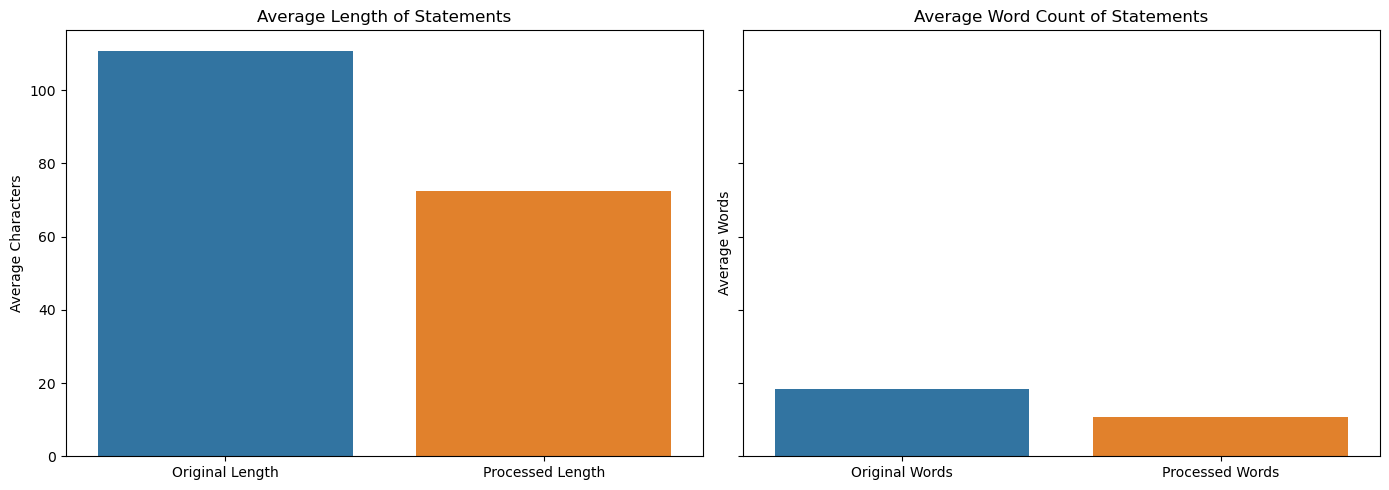

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


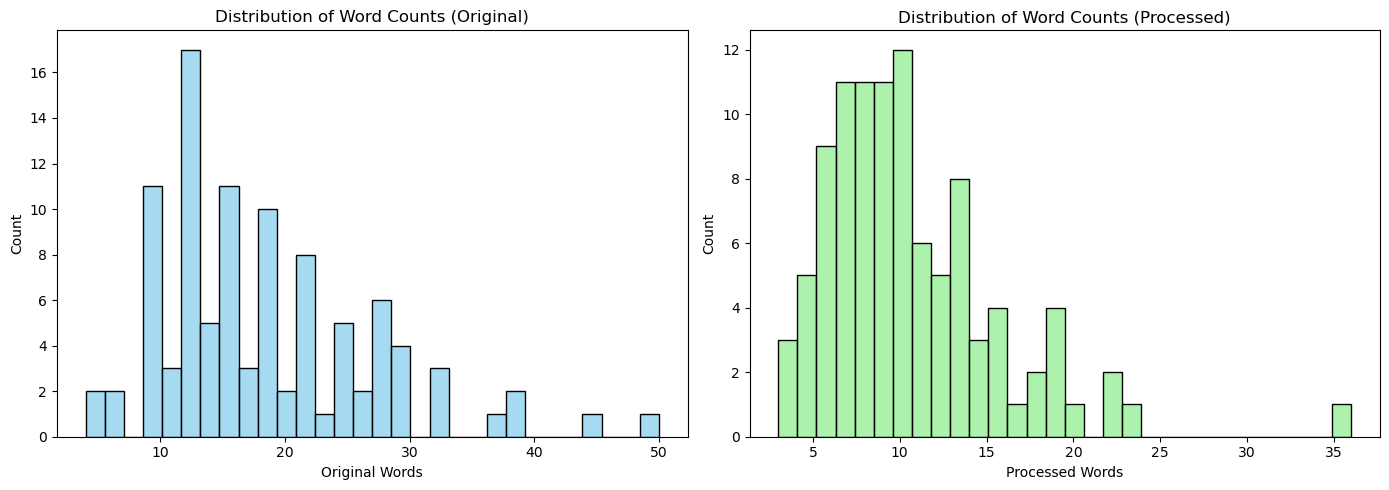

In [5]:
visualize_text_transformations(pd.concat([fnn_train, liar_train]))

#Harmonizing Labels and Merging Datasets

In [6]:
def harmonize_label(label):
    if label in ['pants-fire', 'false', 'barely-true']:
        return 'fake'
    else:
        return 'real'

liar_train['label'] = liar_train['label-liar'].apply(harmonize_label)
liar_dev['label'] = liar_dev['label-liar'].apply(harmonize_label)
liar_test['label'] = liar_test['label-liar'].apply(harmonize_label)

fnn_train.rename(columns={'label_fnn': 'label'}, inplace=True)
fnn_dev.rename(columns={'label_fnn': 'label'}, inplace=True)
fnn_test.rename(columns={'label_fnn': 'label'}, inplace=True)

train = pd.concat([fnn_train[['statement', 'label']], liar_train[['statement', 'label']]])
dev = pd.concat([fnn_dev[['statement', 'label']], liar_dev[['statement', 'label']]])
test = pd.concat([fnn_test[['statement', 'label']], liar_test[['statement', 'label']]])


#Vectorization

In [8]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train['statement'])
X_test = vectorizer.transform(test['statement'])


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train['label'])
y_test = label_encoder.transform(test['label'])


#Model Training and Evaluation

In [9]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, predictions)}")
    print(classification_report(y_test, predictions))
    return model  
# Logistic Regression
print("Logistic Regression Results:")
lr = train_and_evaluate(LogisticRegression(), X_train, y_train, X_test, y_test)

# Decision Tree
print("Decision Tree Results:")
dt = train_and_evaluate(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

# Random Forest
print("Random Forest Results:")
rf = train_and_evaluate(RandomForestClassifier(), X_train, y_train, X_test, y_test)



Logistic Regression Results:
Accuracy: 0.7443965517241379
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       971
           1       0.83      0.70      0.76      1349

    accuracy                           0.74      2320
   macro avg       0.75      0.75      0.74      2320
weighted avg       0.76      0.74      0.75      2320

Decision Tree Results:
Accuracy: 0.9491379310344827
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       971
           1       0.98      0.93      0.96      1349

    accuracy                           0.95      2320
   macro avg       0.95      0.95      0.95      2320
weighted avg       0.95      0.95      0.95      2320

Random Forest Results:
Accuracy: 0.9426724137931034
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       971
           1       0.98      0.92      0.95      1349

    accuracy        

#Visualize Results

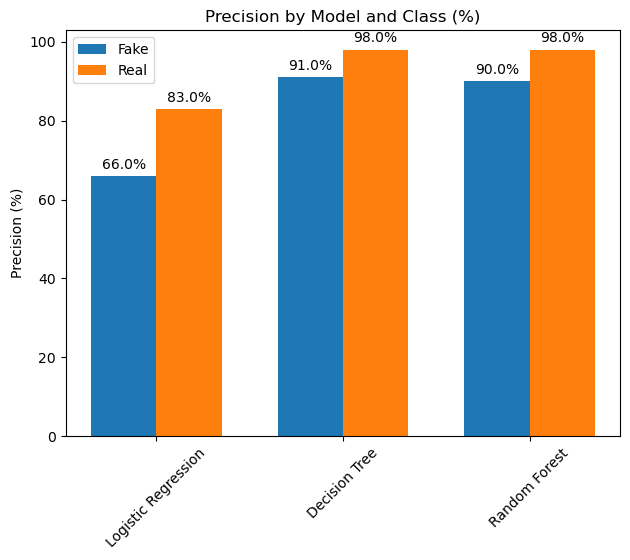

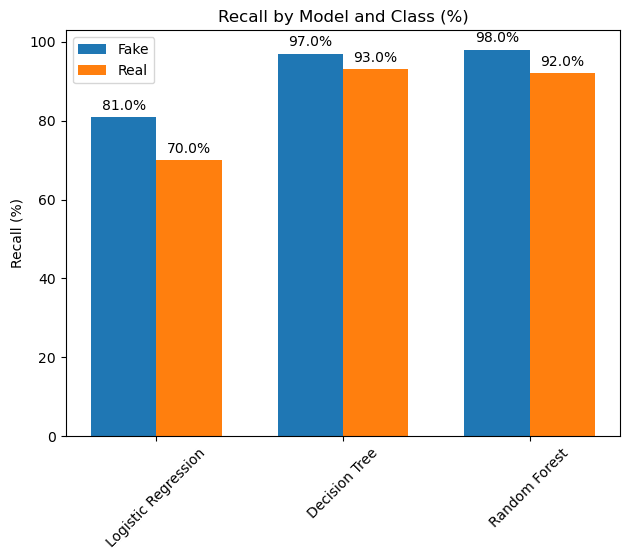

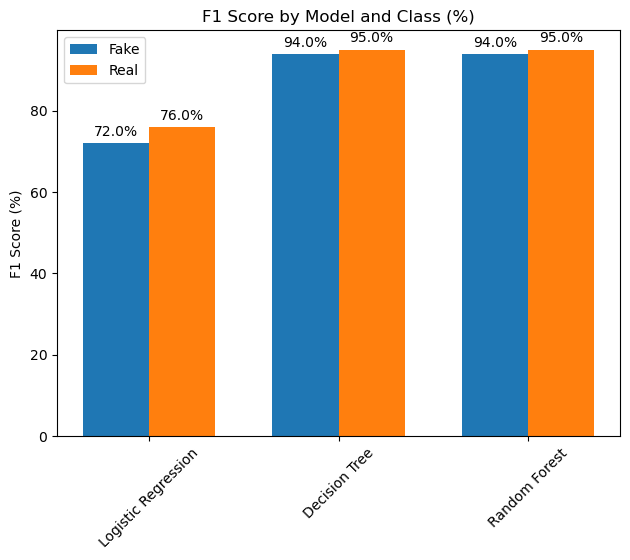

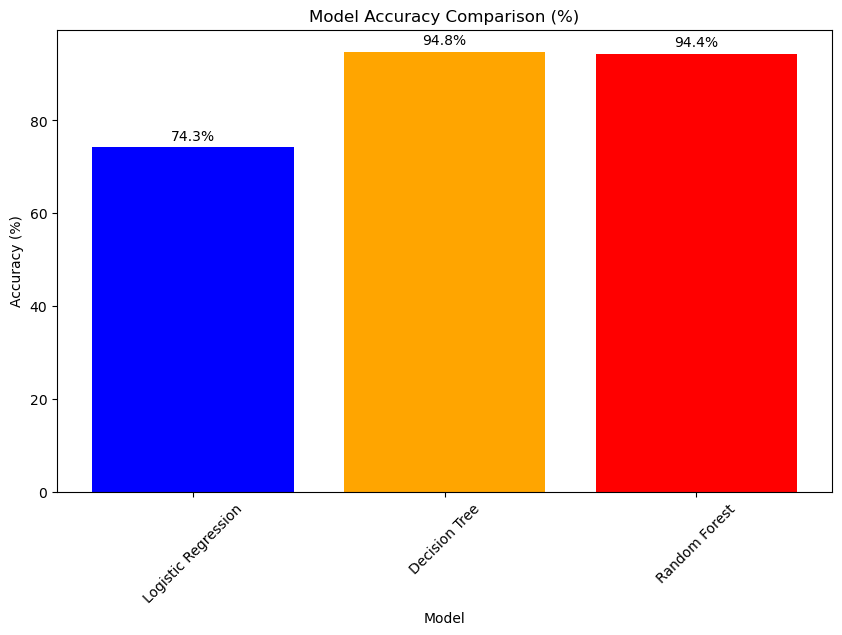

In [10]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Logistic Regression', 'Decision Tree', 'Random Forest']

accuracy = [0.7426724137931034, 0.9482758620689655, 0.9439655172413793]


precision_fake = [0.66, 0.91, 0.90]  # Class 0 (fake)
precision_real = [0.83, 0.98, 0.98]  # Class 1 (real)

recall_fake = [0.81, 0.97, 0.98]  # Class 0 (fake)
recall_real = [0.70, 0.93, 0.92]  # Class 1 (real)

f1_score_fake = [0.72, 0.94, 0.94]  # Class 0 (fake)
f1_score_real = [0.76, 0.95, 0.95]  # Class 1 (real)

def plot_metrics(metric_values, metric_name):
    x = np.arange(len(models))  
    width = 0.35  

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, np.array(metric_values[0]) * 100, width, label='Fake')
    rects2 = ax.bar(x + width/2, np.array(metric_values[1]) * 100, width, label='Real')

    ax.set_ylabel(f'{metric_name} (%)')
    ax.set_title(f'{metric_name} by Model and Class (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    fig.tight_layout()

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.show()

plot_metrics([precision_fake, precision_real], 'Precision')
plot_metrics([recall_fake, recall_real], 'Recall')
plot_metrics([f1_score_fake, f1_score_real], 'F1 Score')

plt.figure(figsize=(10, 6))
rects = plt.bar(models, np.array(accuracy) * 100, color=['blue', 'orange', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison (%)')
plt.xticks(rotation=45)

for rect in rects:
    height = rect.get_height()
    plt.annotate(f'{height:.1f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


#Testing with Manual Entry

In [ ]:
def manual_testing(news):
    processed_news = preprocess_text(news)
    vectorized_news = vectorizer.transform([processed_news])

    lr_pred = lr.predict(vectorized_news)[0]
    dt_pred = dt.predict(vectorized_news)[0]
    rf_pred = rf.predict(vectorized_news)[0]

    predictions = [lr_pred, dt_pred, rf_pred]
    ensemble_pred = 1 if sum(predictions) > len(predictions) / 2 else 0
    
    print("Logistic Regression Prediction:", label_encoder.inverse_transform([lr_pred])[0])
    print("Decision Tree Prediction:", label_encoder.inverse_transform([dt_pred])[0])
    print("Random Forest Prediction:", label_encoder.inverse_transform([rf_pred])[0])
    print("Ensemble Prediction:", label_encoder.inverse_transform([ensemble_pred])[0])

news_input = input("Enter a piece of news to test: ")
manual_testing(news_input)


Tool UI

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

display(HTML("""
<h1 style='text-align: center; color: black;'>Fake News Detection Tool</h1>
"""))

# Create text area for news input
text_area = widgets.Textarea(
    value='',
    placeholder='Type the news text here...',
    description='',
    disabled=False,
    layout=widgets.Layout(width='80%', height='150px', margin='0 auto')
)
submit_button = widgets.Button(
    description='Check News',
    button_style='success',  
    tooltip='Click to check if the news is fake or real',
    icon='check',
    layout=widgets.Layout(width='30%', height='50px', margin='10px auto')
)
output = widgets.Output(layout={'border': '1px solid black', 'margin': '10px auto', 'width': '80%'})

def on_submit_button_clicked(b):
    with output:
        clear_output()
        news_text = text_area.value.strip()
        if not news_text:
            print("Please enter the news text to check.")
            return
        manual_testing(news_text)  
submit_button.on_click(on_submit_button_clicked)
display(widgets.VBox([text_area, submit_button, output], layout=widgets.Layout(align_items='center')))
